# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [21]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


<IPython.core.display.Javascript object>


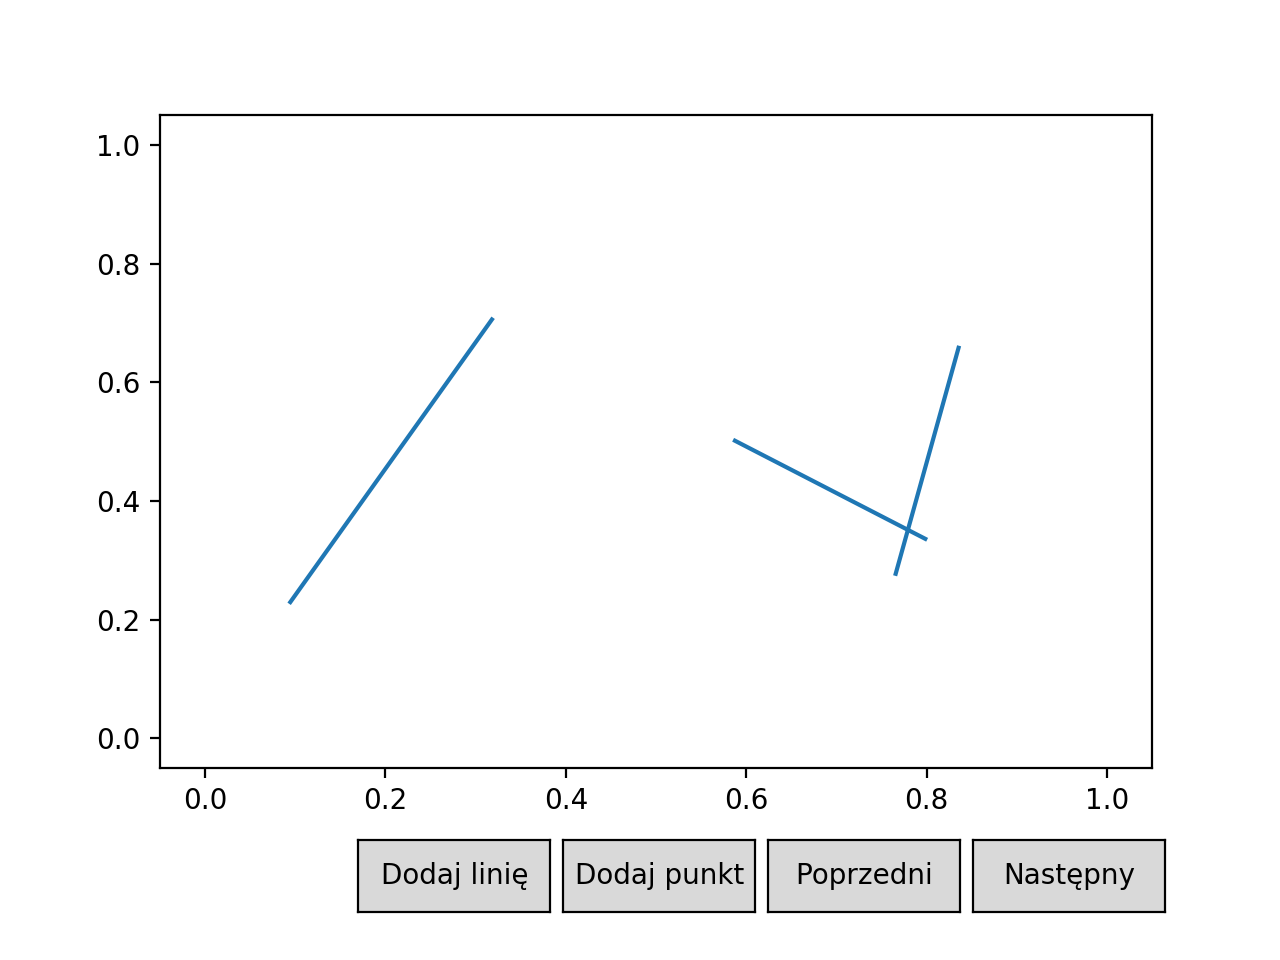

In [22]:
%matplotlib notebook
plotx = Plot()
plotx.draw()

### Zapis

In [23]:
import yaml
p = Plot([plotx.get_added_elements()])

with open('somefiley.json', 'w') as file:
    file.write(p.toJson())
    
with open('somefiley.json', 'r') as file:
    items = file.read()

items = items[1:-1]
items = yaml.load(items, Loader=yaml.FullLoader)

#segments to list
lines = items.get("lines")[0]

## Random creation of segments

In [7]:
%matplotlib notebook

def random_lines(n, corners):
    Lines = []
    lb, rt = corners[0], corners[1]
    
    for i in range(n):
        a = (random.uniform(lb[0], rt[0]), random.uniform(lb[1], rt[1]))
        b = (random.uniform(lb[0], rt[0]), random.uniform(lb[1], rt[1]))
        #discarding if vertical
        if a[0] == b[0]:
            continue
        #discarding if end common with another segment's end
        for j in Lines:
            if j[0] == a or j[0] == b or j[1] == a or j[1] == b:
                continue
        
        Lines.append([a,b])
        
    return Lines
    

### Support methods

In [8]:
def orient(a,b,c):
    m = [a[0], a[1], b[0], b[1], c[0], c[1]]
    return np.linalg.det(np.concatenate((np.reshape(m, (3, 2)), np.ones((3,1))), axis=1))

def collin(x,y,z):
    return min(x[0],y[0]) <= z[0] and z[0] <= max(x[0],y[0]) and min(x[1],y[1]) <= z[1] and z[1] <= max(x[1],y[1])

class seg:
        def __init__(self, line, index):
            self.start = min(line, key = lambda x: x[0])
            self.end = max(line, key = lambda x: x[0])
            self.a = (self.end[1]-self.start[1])/(self.end[0]-self.start[0])
            self.b = self.start[1]-self.a*self.start[0]
            self.id = index
        
        def itself(self):
            return [self.start, self.end]
        
        def __gt__(self,other):
            x=seg.x
            return self.a*x+self.b>other.a*x+other.b
        
        def setx(x):
            seg.x=x

## Wykrywanie istnienia przecięć

In [17]:
from sortedcontainers import SortedList

def do_intersect(segments, corners):

    def intersect(s1, s2):
        x, y = s1
        z, t = s2

        d1 = orient(z, t, x)
        d2 = orient(x, t, y)
        d3 = orient(x, y, z)
        d4 = orient(x, y, t)

        #crossing
        if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
            return True

        #collinear and intersecting
        elif d1 == 0 and collin(z, t, x):
            return True
        elif d2 == 0 and collin(z, t, y):
            return True
        elif d3 == 0 and collin(x, y, z):
            return True
        elif d4 == 0 and collin(x, y, t):
            return True

        return False
    
    T = SortedList()
    Q = SortedList(key = lambda x: x[0])
    
    for i in range(len(segments)):
        s = seg(segments[i], i)
        #to events: x coordinate (sort), start(True/False), index (refer), element (comfort)
        Q.add((s.start[0], True, i, s))
        Q.add((s.end[0], False, i, s))
        
    
    #printing
    current = []
    scenes = [Scene([PointsCollection([])], [LinesCollection(segments)])]
    crossed = False
    
    while Q.__len__() > 0:

        moment = Q[0]
        p = moment[3]
        seg.setx(moment[0])

        #if beginning of segment
        if moment[1]:
            T.update([p])
            p_index = T.index(p)
            prv, nxt = p_index-1, p_index+1
            a = p.itself()   
            
            if prv >=0:
                b = T[prv].itself()
                if intersect(a, b):
                    return True, scenes
                
            if nxt < T.__len__():
                c = T[nxt].itself()
                if intersect(a, c):
                    return True, scenes
                
            current.append(p.itself()) 
            
            to_print = []
            for c in current:
                to_print.append(c)
        
        scenes.append(Scene([PointsCollection([])], [LinesCollection(segments), LinesCollection(to_print, color = "cyan"), LinesCollection([[(moment[0], corners[0][1]), (moment[0], corners[1][1])]], color = "yellow")]))   
        
        #if end of segment
        if moment[1] == False:
            #looking for index
            for i in range(len(T)):
                if T[i] == p:
                    p_index = i
            prv, nxt = p_index-1, p_index+1
            
            if prv >= 0 and nxt < T.__len__():
                if intersect( T[prv].itself(), T[nxt].itself() ):
                     return True, scenes
                
            T.__delitem__(p_index) 
            current.remove(p.itself())
        Q.remove(moment)
       
    return False, scenes

True


<IPython.core.display.Javascript object>


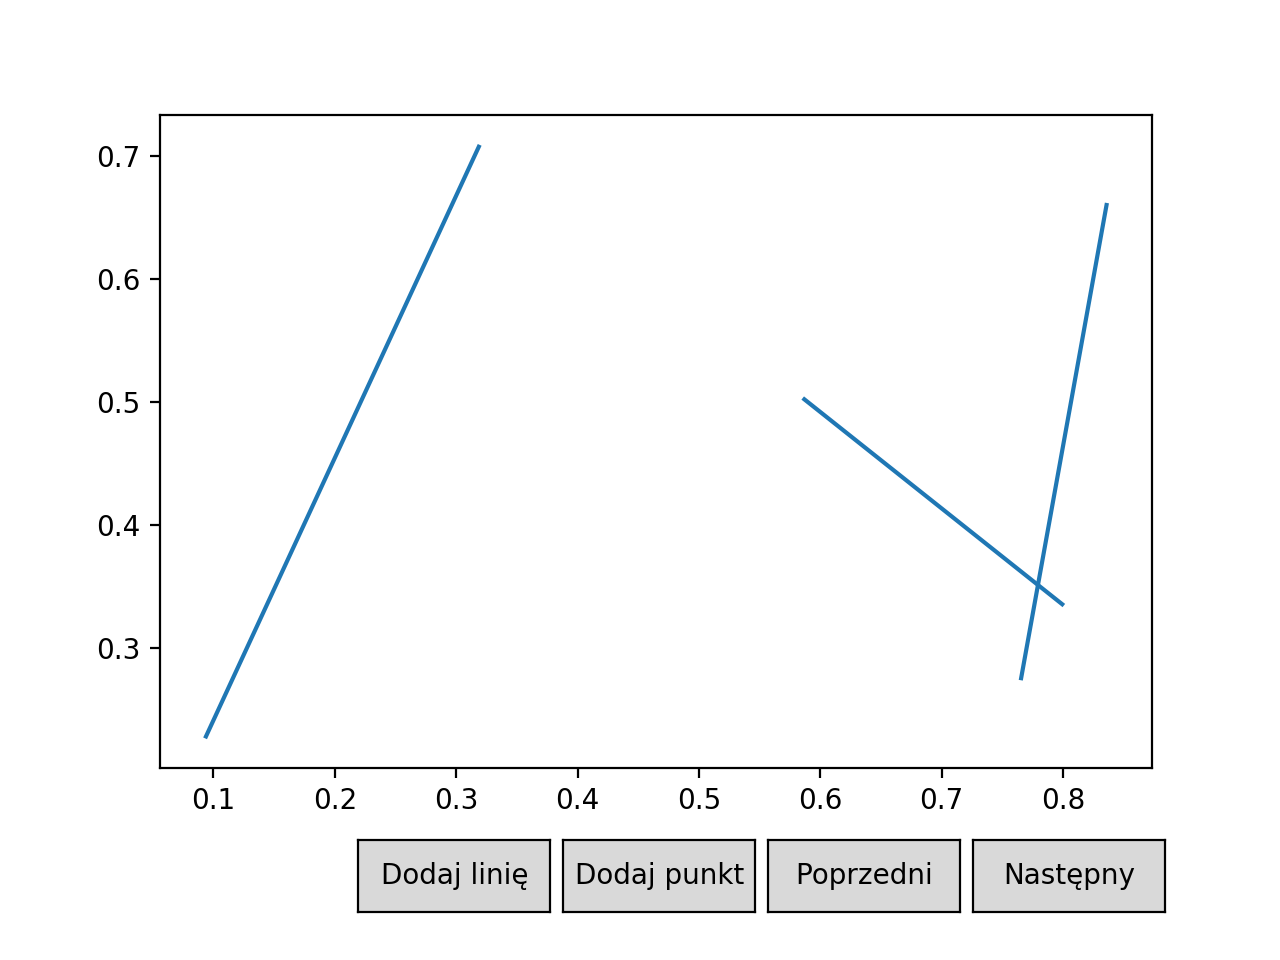

In [24]:
segments, corners = lines, [(0,0), (1,1)]

# corners, segments = [(0,0), (10,10)], random_lines(10, corners)

intersect, scenes = do_intersect(segments, corners)
print(intersect)
plot = Plot(scenes)
plot.draw()

## Wypisywanie przecięć

In [25]:
from sortedcontainers import SortedList

def intersections(segments, corners, scenes=[]):
    class Point:
        def __init__(self, crd, ptype, other_end):
            self.x = crd[0]
            self.y = crd[1]
            self.ptype = ptype # 0 - left, 1 - right, 2 - intersection
            self.other_end = other_end
    
    
    q1 = [Point(s[0], 0, s[1]) if s[0][0] <= s[1][0] else Point(s[0], 1, s[1]) for s in segments]
    q2 = [Point(s[1], 0, s[0]) if s[1][0] <= s[0][0] else Point(s[1], 1, s[0]) for s in segments]
    Q = q1 + q2
    Q = SortedList(Q, key = lambda x: x.x)
    
    
    T = SortedList(key = lambda x: x.y)             
    
    def prd(p):
        if T.index(p) == 0:
            return False
        else:
            return T.__getitem__(T.index(p)-1)
        
    def ssc(p):
        if T.index(p) == T.__len__()-1:
            return False
        else:
            return T.__getitem__(T.index(p)+1)
        
    def find(p,other = True):
        if other == True:
            e = Point(p.other_end, 0, (p.x,p.y))
        else:
            e = p
        for j in range(T.__len__()):
            i = T.__getitem__(j)
            if i.x == e.x and i.y == e.y and e.other_end == i.other_end:
                return (True, j)
                
    def intersect(a,b):
        def orient(a,b,c):
            m = [a[0], a[1], b[0], b[1], c[0], c[1]]
            det = np.linalg.det(np.concatenate((np.reshape(m, (3, 2)), np.ones((3,1))), axis=1))
            if det == 0:
                return 0
            elif det > 0:
                return 1
            else:
                return 2
        a1 = (a.x,a.y)
        b1 = (b.x,b.y)
        a2 = a.other_end
        b2 = b.other_end
        d1 = orient(b1, b2, a1)
        d2 = orient(b1, b2, a2)
        d3 = orient(a1, a2, b1)
        d4 = orient(a1, a2, b2)
        if d1 != d2 and d3 != d4:
            return True
        else:
            return False
        
    def common_point(x,y):
        A = (x.x,x.y)
        B = x.other_end
        C = (y.x, y.y)
        D = y.other_end
        a1 = np.array([[1,A[0]],[1,B[0]]])
        b1 = np.array([A[1],B[1]])
        a2 = np.array([[1,C[0]],[1,D[0]]])
        b2 = np.array([C[1],D[1]])
        s1 = np.linalg.solve(a1, b1)
        s2 = np.linalg.solve(a2, b2)
        return ((s2[0]-s1[0])/(s1[1]-s2[1]), (s1[1]*s2[0]-s1[0]*s2[1])/(s1[1]-s2[1]))       
    
    crossings = []
    scenes = []
    while Q.__len__() > 0:
        p = Q.pop(0)
        
        col = 'Red'
        
        if p.ptype == 0:
            T.add(p)
            if(prd(p)):
                if intersect(p, prd(p)):
                    c = common_point(p,prd(p))
                    crossings.append(c)
                    Q.add(Point(c,2,()))
            if(ssc(p)):
                if intersect(p, ssc(p)):
                    c = common_point(p,ssc(p))
                    crossings.append(c)
                    Q.add(Point(c,2,()))
        elif p.ptype == 1:
            T.add(p)
            if prd(p) and ssc(p):
                if intersect(prd(p), ssc(p)):
                    c = common_point(prd(p),ssc(p))
                    crossings.append(c)
                    if not find(Point(c,2,()), False):
                        Q.add(Point(c,2,()))
            if find(p)[0]:
                T.__delitem__(find(p)[1])
        else:
            col = 'Yellow'
            
        scenes.append(Scene([PointsCollection([])],[ LinesCollection(segments), LinesCollection([ [(p.x, corners[0][1]), (p.x, corners[1][1])] ], color=col)]))

    return len(crossings), crossings, scenes

<IPython.core.display.Javascript object>


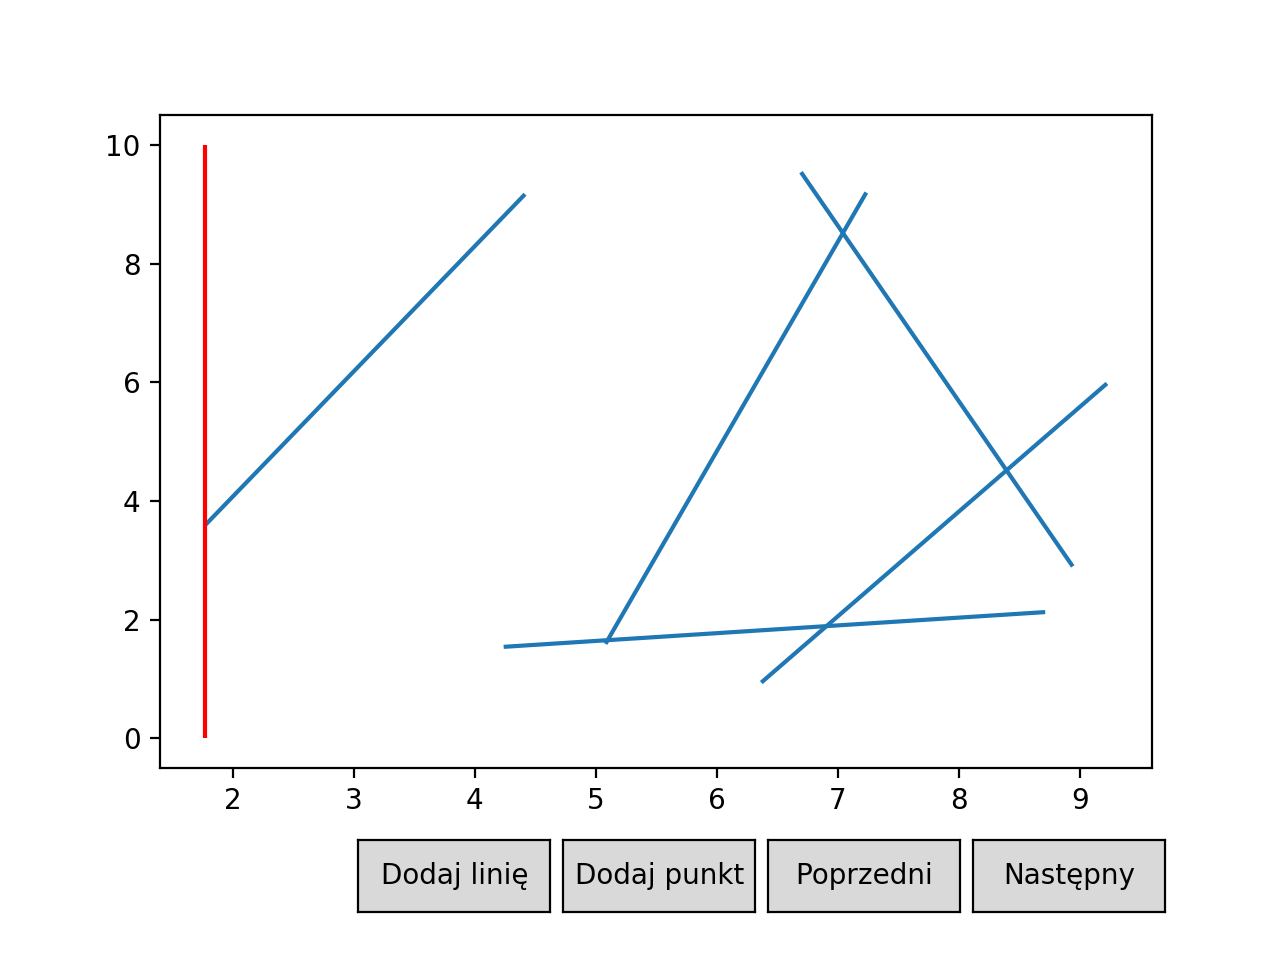

2
(5.097940141200217, 1.6539794345649117)
(6.905458506414674, 1.8906662638543776)


In [28]:
#test sweep with coordinates

corners, x = [(0,0), (10,10)], random_lines(5, corners)
# x, corners = lines, [(0,0),(1,1)]

scenes = [Scene( [PointsCollection()], [LinesCollection(x)])]

ans, cross_points, scenes = intersections(x, corners)
    
plot = Plot(scenes)
plot.draw()
print(ans)
for i in cross_points:
    print(i)